## A more complex example

In this example we will simulate a simple [autocolimator](https://en.wikipedia.org/wiki/Autocollimator) system.

The autocolimator system will be made of a point source (**R**), a beam splitting cube (**BS**), a colimator lens (**L**), and a CCD (**C**).

In this first example, this will be used to check if a mirror (**M1**) is parallel to the optical axis.


In [1]:
from pyoptools.all import *
from numpy import pi

Loading component library Edmund  from files  ['/home/rdg/repos/pyoptools/pyoptools/raytrace/library/Edmund/edmund_spherical.cmp']
Loading component library Thorlabs  from files  ['/home/rdg/repos/pyoptools/pyoptools/raytrace/library/Thorlabs/thorlabs_cylindrical.cmp', '/home/rdg/repos/pyoptools/pyoptools/raytrace/library/Thorlabs/thorlabs_spherical.cmp']


In [2]:
R=point_source_c(span=(0.06,0.06),num_rays=(5,5),wavelength=.65)
BS=BeamSplittingCube(size=25,reflectivity=.5,material=material.schott["N-BK7"])
L=library.Edmund.get("32494")
C=CCD()
M1= RectMirror(size=(25, 25, 5),material=material.schott["N-BK7"], reflectivity=1.)

S=System(complist=[(C,(20,0,20),(0,pi/2,0)),(BS,(0,0,20),(0,0,0)),(L,(0,0,158.5),(0,-pi,0)),(M1,(0,0,170),(0,0,0))],n=1.)


S.ray_add(R)
S.propagate()

In [3]:
Plot3D(S,center=(0,0,300), size=(600,100),scale=2,rot=[(0,0,-3*pi/8),(0,3*pi/8,0)])

/home/rdg/.local/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=OrthographicCamera(bottom=-100.0, children=(DirectionalLight(intensity=0.7, position=(0.0, 100…

In this example, the ray trace proceesd as follow:

1. 25 rays come out from a the point source (**R**) 
2. They enter the beam splitting cube (**BS**), and propagate to the **BS** reflective surface. In the first interfase of **BS** the rays get diffracted.
3. In the reflective surface, the original rays continue propagating, and a new set of rays (reflected) get created.
4. The set of reflected rays get propagated out of the cube, and do not get propagated anymore as there are no optical components they can intersect.
5. The transmitted rays get propagated out of the cube, until they intersect the lens (**L**).
6. The rays get propagated through the lens. At each lens surface, the rays get refracted taking in to account the incidence angle, and the refraction index at each side of the surface. **Note:** This happens at all surface intersection, at all components.
7. The rays get propagated until they hit the reflective surface at the mirror, and bounce back, propagating again in the lens direction.
8. The rays get propagated through the lens and into the **BS**.
9. In the reflective surface of the **BS** a new set of reflected rays get created, and are propagated in the **CCD** direction.
10. the transmitted rays get propagated out of the **BS** and overlap the point source.

From the interactive raytrace plot, one can get an idea about what is going on, but most of the time we need to see how the ray intersect a surface. In this case, we can get an spot diagram from the **CCD** as shown in the next plot.


Populating the interactive namespace from numpy and matplotlib


/home/rdg/.local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['Polygon', 'unwrap', 'sqrt', 'cross']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


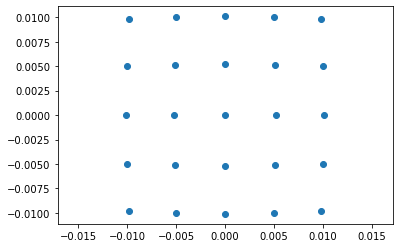

In [4]:
%pylab inline
spot_diagram(C)

If the lens was ideal, and the distance between the lens and the point source was adequatelly adjusted, the spot diagram would show all the 25 rays hitting at exact the same coordinates in the **CCD**. But as we are simulating a "real" doublet, we have a cube that introduces some spherical aberration in the path, and the distance was optimized in .5 mm steps, we get a spot in the CCD that is about 20 um in diameter, but as expected the center of such spot is the (0mm, 0mm) coordinate f the **CCD**.

In the next example the mirror will be tilted 10 urads

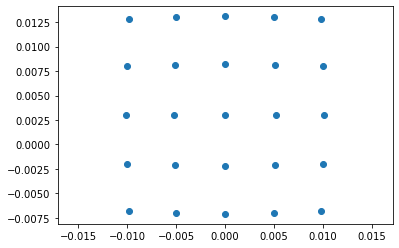

In [5]:
R=point_source_c(span=(0.06,0.06),num_rays=(5,5),wavelength=.65)
BS=BeamSplittingCube(size=25,reflectivity=.5,material=material.schott["N-BK7"])
L=library.Edmund.get("32494")
C=CCD()
M1= RectMirror(size=(25, 25, 5),material=material.schott["N-BK7"], reflectivity=1.)

S=System(complist=[(C,(20,0,20),(0,pi/2,0)),(BS,(0,0,20),(0,0,0)),(L,(0,0,158.5),(0,-pi,0)),(M1,(0,0,170),(10.E-6,0,0))],n=1.)


S.ray_add(R)
S.propagate()

spot_diagram(C)

In this case we see that the spot is hitting the CCD approximatelly at (0mm, 0.0025 mm).

Some times getting an approximate position of the center of the spot from a plot is not enough. In such cases we can use the [hit_list](../../pyoptools.raytrace.comp_lib.rst#pyoptools.raytrace.comp_lib.CCD.hit_list) property from the **CCD**. From this list we can get the intersection point of each ray and for example use the average in X and in Y to estimate the spot centroid position.

In [6]:
cx=0.
cy=0.

for c,r in C.hit_list:
    cx=cx+c[0]
    cy=cy+c[1]
    
cx=cx/25
cy=cy/25

print("CMX",cx,"CMY",cy)

CMX 5.115491363838487e-15 CMY 0.002998219837423476


In this case, the resulting spot diagram is similar to the previous one, but we can see the central spot is not located at the origin of the **CCD** anymore, but at the coordinate (0 mm, 0.003 mm)

In the ideal case, taking in to account the reported focal length of the lens, and the tilting of the mirror, the coorditates of the point should be

In [7]:
f=150.
alpha=10e-6
cy_=f*2.*alpha
print("CMY-Estimated",cy_)

CMY-Estimated 0.003


As we can see, the estimated value correspond very well with the simulation.